In [1]:
%matplotlib inline

In [2]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import importlib


import pandas as pd

import eeg_utils as eeg

# Artefact rejection: Epoche amplitude threshold

ways of artefact rejection

_see Luck, p. 189_

1. __absolute voltage rejection approach__: Abweichung von 0: absolutes Signal nach Baseline reduktion (von herrn rüsseler verwendet, +-80 bzw +-100, baseline korrektur vorher absolut notwendig, vermutlich über Annotation zu implementieren)


2. __epoch-wide Peak to Peak Amplitude __( MNE nur eingebaut bei ject parameter von Epoch)


........

3. __moving window peak to peak amplitude__ : 200 ms moving window (50 ms sprünge) jeweils maximale peak to peak nehmen, dann von ganzer epoche maximale peak to peak nehmen, gegen threshold vergleichen -> robust auch gegen slow drifts

 __---> wird genommen__

............

4. __Step Function__ (s196) moving window (e.g. 200 ms) difference between mean of first to second half of window


In [3]:
filenames = os.listdir("raw_ICA_corrected/")

## peak to peak  epoch wide

In [7]:
def getEpochsEpochWidePeakToPeak(filename,
              variant = ""
              ,tmin = -0.2, tmax=0.8, 
              baseline = (-0.2,0),
              
              
             eegPeakToPeakThreshold = 150e-6
              
              
             ):
    
    
    
    
    raw_clean = mne.io.read_raw_fif("raw_ICA_corrected_TF"+variant+"/"+filename,
                                   preload=True
                                   )

    #only stimuli
    event_id = dict(
                    stim_1=21, stim_2=22,stim_3=23,stim_4=24
                   )
    events = mne.find_events(raw_clean)

    epochs =  mne.Epochs(raw_clean, events,event_id,
                        tmin = tmin, tmax=tmax,
                        baseline = baseline,
                        preload=True
                        )                   

    # only take first 240 (könnte ja noch in den nächsten Block rübergehen)
    epochs = epochs[0:240]

    epochs = epochs.drop_bad(reject=dict(eeg=eegPeakToPeakThreshold) ) # 80 µV Peak to Peak
    return epochs

## moving window peak-to-peak amplitude

In [17]:
def getEpochsMovingWindowPeakToPeak(
                filename,
              variant = ""
              ,tmin = -0.2, tmax=0.8, 
              baseline = (-0.2,0),
              
              
             threshold_moving_peakToPeak_epoch = 300e-6
              
              
             ):

    raw_clean = mne.io.read_raw_fif("raw_ICA_corrected"+variant+"/"+filename,
                   preload=True
                   )

    #only stimuli
    event_id = dict(
    stim_1=21, stim_2=22,stim_3=23,stim_4=24
    )
    events = mne.find_events(raw_clean)

    epochs =  mne.Epochs(raw_clean, events,event_id,
        tmin = tmin, tmax=tmax,
        baseline = baseline,
        preload=True
        )                   
    # only take first 240 (könnte ja noch in den nächsten Block rübergehen)
    epochs = epochs[0:240]

    data = epochs.get_data()
    data = data[:,:28,:]

    # 10 *4 ms = 40 ms window shift
    # 200 ms window

    n_shifts = data.shape[2] // 10
    n_shifts = n_shifts -  ( 200 //40) +1


    max_peakToPeak_epoch = np.zeros((240,28))
    for i in range(n_shifts):
        begin = i*10
        end = i*10 + 50
        peakToPeak_inWindow =  data[:,:,begin:end].max(axis=2)- data[:,:,begin:end].min(axis=2) 
        max_peakToPeak_epoch = np.maximum(max_peakToPeak_epoch,peakToPeak_inWindow )


    rejected = (np.sum(max_peakToPeak_epoch > threshold_moving_peakToPeak_epoch, axis=1)>0)

    epochs = epochs.drop(indices=rejected, reason="MovingPeakToPeakAmpl120")

    return epochs

# iterativer aufruf...

__für TF -> moving window zu ignorieren

In [18]:
rej_stats = []
for file in filenames:
    
    id_ = file.split("_")[0]
    print(id_)
    epochs = getEpochsMovingWindowPeakToPeak(file)
    epochs.save("epochs_MovingWindowPeakToPeak/"+id_+"-epo.fif")
    
    try:
        evoked = epochs.average()
        evoked.save("evoked__MovingWindowPeakToPeak/"+id_+"-ave.fif")
        rej_stats.append([id_,evoked.nave])
    except ZeroDivisionError:
        rej_stats.append([id_,0])
           
        
    
    
                                  

AAR23B1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\AAR23B1_raw.fif...
    Range : 37368 ... 105100 =    149.472 ...   420.400 secs
Ready.
Reading 0 ... 67732  =      0.000 ...   270.928 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
ACE11B1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\ACE11B1_raw.fif...
    Range : 19699 ... 76334 =     78.796 ...   305.336 secs
Ready.
Reading 0 ... 56635  =      0.000 ...   226.540 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 b

Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
BDS23B1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\BDS23B1_raw.fif...
    Range : 23169 ... 77124 =     92.676 ...   308.496 secs
Ready.
Reading 0 ... 53955  =      0.000 ...   215.820 secs...
492 events found
Event IDs: [ 1  2  3  4 11 12 14 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
BGI23S1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\BGI23S1_raw.fif...
    Range : 12078 ... 68078 =     48.312 ...   272.312 secs
Ready.
Reading 0 ... 56000  =      0.000 ...   224.000 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not set

Event IDs: [ 1  2  3  4 11 12 14 21 22 23 24]
242 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 242 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
CMT16M1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\CMT16M1_raw.fif...
    Range : 32540 ... 86936 =    130.160 ...   347.744 secs
Ready.
Reading 0 ... 54396  =      0.000 ...   217.584 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
CUM15K1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\CUM15K1_raw.fif...
    Range : 32908 ... 87567 =    131.632 ...   350.268 secs
Ready.
Reading 0 ... 54659  =      0.

Ready.
Reading 0 ... 47820  =      0.000 ...   191.280 secs...
492 events found
Event IDs: [ 1  2  3  4 11 12 14 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 2 epochs
IGN31N1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\IGN31N1_raw.fif...
    Range : 19520 ... 72094 =     78.080 ...   288.376 secs
Ready.
Reading 0 ... 52574  =      0.000 ...   210.296 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
IJO20G1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\IJO20G1_raw.fif...
    Range : 8344 

    Range : 14821 ... 66402 =     59.284 ...   265.608 secs
Ready.
Reading 0 ... 51581  =      0.000 ...   206.324 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
LRM12B1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\LRM12B1_raw.fif...
    Range : 28942 ... 76830 =    115.768 ...   307.320 secs
Ready.
Reading 0 ... 47888  =      0.000 ...   191.552 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
MAI03B1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_IC

    Range : 46049 ... 128119 =    184.196 ...   512.476 secs
Ready.
Reading 0 ... 82070  =      0.000 ...   328.280 secs...
490 events found
Event IDs: [ 1  2  3  4 11 12 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 2 epochs
MUH04O1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\MUH04O1_raw.fif...
    Range : 35854 ... 89717 =    143.416 ...   358.868 secs
Ready.
Reading 0 ... 53863  =      0.000 ...   215.452 secs...
497 events found
Event IDs: [ 1  2  3  4 11 12 13 14 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
MWA27N1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_Pr

Dropped 1 epoch
VGR24B1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\VGR24B1_raw.fif...
    Range : 23176 ... 99253 =     92.704 ...   397.012 secs
Ready.
Reading 0 ... 76077  =      0.000 ...   304.308 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 0 epochs
VJM28H1
Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected_TF\VJM28H1_raw.fif...
    Range : 26497 ... 90878 =    105.988 ...   363.512 secs
Ready.
Reading 0 ... 64381  =      0.000 ...   257.524 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time

In [ ]:
bad_ids = ["MDA20B1", "BNR25W1","EKC18D1","MMK25B1"]

In [19]:
pd.DataFrame(rej_stats,columns=["Subject_ID","acc"]).sort_values("acc")

Subject_ID  acc
68    MDA20B1   57
22    BNR25W1  106
73    MMK25B1  168
88    SJO18S1  216
6     AJH13B1  222
2     ADD25P1  226
53    JJR09B1  227
21    BMR01N1  231
37    EKC18D1  233
8     AKK31B1  235
70    MGK07B1  236
78    MTC06B1  236
28    CAB19N1  236
25    BRS27B1  236
77    MSJ07H1  237
52    JAT08L1  237
87    SJN01B1  237
18    BHC19K1  237
82    NVM07B1  237
67    MBA25B1  238
47    HWH15C1  238
49    IJO20G1  238
79    MTF03B1  238
10     ARO12C  238
58    KEE25B1  239
46    HTV10S1  239
72    MLS07B1  239
36    EJE29B1  239
42    GFD21N1  239
76    MNI23B1  239
..        ...  ...
12    AVR16F1  240
11    ATO21W1  240
9     ARL17K1  240
7     AJL30S1  240
5     AIV25B1  240
4     AHR27N1  240
1     ACE11B1  240
13    AWJ28B1  240
27    BWR08M1  240
29    CBV10N1  240
30    CFF19P1  240
54    JRB09F1  240
51    ITE03D1  240
50    IMA20B1  240
98    VWG04S1  240
48    IGN31N1  240
45    HHB22B1  240
44    GWD17F1  240
43    GKN11N1  240
41    GAK15L1  240
40    ERT08F1  240
39    EMN30M1  240
38     EMG01D  240
35    EJA24B1  240
34    EFN26K1  240
33    CUM15K1  240
32    CMT16M1  240
31    CGC24W1  240
57    KAE12N1  240
99    WJJ05M1  240

[100 rows x 2 columns]

In [ ]:
bad_ids = ["MDA20B1", "BNR25W1","EKC18D1","MMK25B1"]
#noch drei mehr evtll rausschmeissen

Opening raw data file I:\MASTERARBEIT\Expl_Impl_Learning\09_PreparationEEG\raw_ICA_corrected\CMT16M1_raw.fif...
    Range : 32540 ... 86936 =    130.160 ...   347.744 secs
Ready.
Reading 0 ... 54396  =      0.000 ...   217.584 secs...
484 events found
Event IDs: [ 1  2  3  4 21 22 23 24]
240 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 240 events and 251 original time points ...
0 bad epochs dropped
Dropped 1 epoch


In [69]:
df = pd.DataFrame(rej_stats, columns=["id","n_acc_epochs"]).sort_values("n_acc_epochs")

### moving window peak to peak 

In [14]:
f = filenames[1]

In [15]:
f

'ACE11B1_raw.fif'

In [171]:
a_df = pd.DataFrame(a, columns=["id"]+list(map(str,[50,60,70,80,90,100,120,140,160])))

(array([ 2.,  2.,  0.,  2.,  2.,  1.,  0.,  2.,  9., 80.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

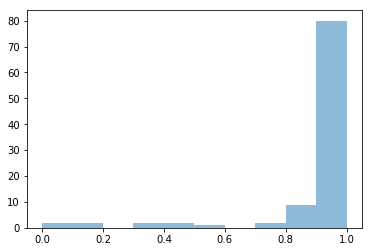

In [176]:
#plt.hist(a_df["50"],alpha=0.5)
#plt.hist(a_df["60"],alpha=0.5)
#plt.hist(a_df["70"],alpha=0.5)
#plt.hist(a_df["80"],alpha=0.5)
#plt.hist(a_df["90"],alpha=0.5)
#plt.hist(a_df["100"],alpha=0.5)
plt.hist(a_df["120"],alpha=0.5)
#plt.hist(a_df["140"],alpha=0.5)


In [ ]:
["MDA20B1", "BNR25W1","EKC18D1","MMK25B1"]

In [182]:
a_df.sort_values("120")

id        50        60        70        80        90  \
68  MDA20B1_raw.fif  0.000000  0.000000  0.000000  0.000000  0.000000   
22  BNR25W1_raw.fif  0.000000  0.000000  0.000000  0.000000  0.000000   
73  MMK25B1_raw.fif  0.000000  0.000000  0.000000  0.000000  0.000000   
37  EKC18D1_raw.fif  0.000000  0.000000  0.000000  0.000000  0.000000   
78  MTC06B1_raw.fif  0.000000  0.000000  0.000000  0.000000  0.004167   
55  JRR03B1_raw.fif  0.000000  0.000000  0.000000  0.000000  0.012500   
36  EJE29B1_raw.fif  0.000000  0.000000  0.000000  0.004167  0.054167   
58  KEE25B1_raw.fif  0.000000  0.000000  0.000000  0.020833  0.070833   
17  BGI23S1_raw.fif  0.000000  0.000000  0.000000  0.000000  0.025000   
21  BMR01N1_raw.fif  0.000000  0.000000  0.004167  0.037500  0.183333   
88  SJO18S1_raw.fif  0.000000  0.004167  0.054167  0.241667  0.491667   
35  EJA24B1_raw.fif  0.000000  0.000000  0.000000  0.029167  0.154167   
82  NVM07B1_raw.fif  0.000000  0.000000  0.025000  0.112500  0.266667   
72  MLS07B1_raw.fif  0.000000  0.062500  0.250000  0.445833  0.658333   
2   ADD25P1_raw.fif  0.000000  0.012500  0.129167  0.283333  0.450000   
99  WJJ05M1_raw.fif  0.000000  0.000000  0.000000  0.004167  0.041667   
67  MBA25B1_raw.fif  0.000000  0.012500  0.116667  0.350000  0.616667   
6   AJH13B1_raw.fif  0.000000  0.004167  0.145833  0.500000  0.758333   
70  MGK07B1_raw.fif  0.000000  0.000000  0.004167  0.008333  0.141667   
28  CAB19N1_raw.fif  0.000000  0.008333  0.100000  0.316667  0.579167   
87  SJN01B1_raw.fif  0.095833  0.266667  0.466667  0.575000  0.708333   
26  BSE11B1_raw.fif  0.004167  0.033333  0.179167  0.408333  0.595833   
79  MTF03B1_raw.fif  0.000000  0.000000  0.037500  0.179167  0.416667   
20  BML24M1_raw.fif  0.000000  0.000000  0.016667  0.133333  0.366667   
53  JJR09B1_raw.fif  0.079167  0.383333  0.725000  0.858333  0.891667   
30  CFF19P1_raw.fif  0.000000  0.045833  0.229167  0.462500  0.679167   
7   AJL30S1_raw.fif  0.020833  0.216667  0.445833  0.633333  0.779167   
56  KAA24N1_raw.fif  0.008333  0.200000  0.491667  0.675000  0.795833   
76  MNI23B1_raw.fif  0.008333  0.137500  0.437500  0.687500  0.837500   
31  CGC24W1_raw.fif  0.000000  0.008333  0.050000  0.212500  0.429167   
..              ...       ...       ...       ...       ...       ...   
60  KHM10S1_raw.fif  0.075000  0.487500  0.766667  0.904167  0.941667   
69  MFB01B1_raw.fif  0.225000  0.708333  0.891667  0.954167  0.983333   
59   KHB16F_raw.fif  0.037500  0.304167  0.662500  0.858333  0.954167   
93  UFA18E1_raw.fif  0.025000  0.212500  0.500000  0.737500  0.841667   
51  ITE03D1_raw.fif  0.000000  0.070833  0.404167  0.729167  0.900000   
50  IMA20B1_raw.fif  0.000000  0.070833  0.329167  0.720833  0.908333   
46  HTV10S1_raw.fif  0.012500  0.162500  0.512500  0.754167  0.866667   
95  VGR24B1_raw.fif  0.004167  0.125000  0.691667  0.950000  0.983333   
43  GKN11N1_raw.fif  0.000000  0.075000  0.291667  0.525000  0.729167   
97  VJR20B1_raw.fif  0.008333  0.300000  0.700000  0.937500  0.979167   
32  CMT16M1_raw.fif  0.291667  0.629167  0.829167  0.908333  0.945833   
15  BDR13B1_raw.fif  0.075000  0.529167  0.858333  0.983333  0.987500   
84   SBL15H_raw.fif  0.187500  0.525000  0.787500  0.904167  0.979167   
89  SKB08F1_raw.fif  0.191667  0.666667  0.879167  0.945833  0.995833   
96  VJM28H1_raw.fif  0.054167  0.341667  0.691667  0.912500  0.970833   
33  CUM15K1_raw.fif  0.220833  0.641667  0.883333  0.975000  0.987500   
12  AVR16F1_raw.fif  0.641667  0.891667  0.970833  0.995833  0.995833   
14  BAM16A1_raw.fif  0.062500  0.445833  0.833333  0.945833  0.995833   
34  EFN26K1_raw.fif  0.241667  0.633333  0.850000  0.950000  0.975000   
64  LRM12B1_raw.fif  0.004167  0.058333  0.420833  0.758333  0.920833   
62  KMS05F1_raw.fif  0.062500  0.529167  0.895833  0.983333  0.991667   
61  KJF03S1_raw.fif  0.083333  0.400000  0.725000  0.908333  0.958333   
19  BMI31E1_raw.fif  0.258333  0.645833  0.900000  0.975000  0.995833   
23

### 120 µV optimal

In [133]:
np.sum(max_peakToPeak_epoch > threshold_moving_peakToPeak_epoch, axis=1)>0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,